In [11]:
import sys
import matplotlib.colors as clr
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from astropy.io import fits
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
from sklearn.mixture import GaussianMixture

In [2]:
os.chdir('gcr-catalogs-master/')
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCR import GCRQuery

In [3]:
cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons')

#Apply cuts
cuts = [
    GCRQuery('ra > 51'),
    GCRQuery('ra < 56'),
    GCRQuery('dec > -42'),
    GCRQuery('dec < -38'),
    #GCRQuery('redshift_truth > 0.25'),
    #GCRQuery('redshift_truth < 0.27'),
    GCRQuery('truth_type == 1'),   # select galaxy
    GCRQuery('is_good_match == True'),
    GCRQuery('is_nearest_neighbor == True'),
    GCRQuery((np.isfinite, 'mag_g_cModel')), # Select objects that have g-band magnitudes
    GCRQuery((np.isfinite, 'mag_r_cModel')), # Select objects that have r-band magnitudes
    GCRQuery((np.isfinite, 'mag_i_cModel')), # Select objects that have i-band magnitudes
    GCRQuery((np.isfinite, 'mag_g')), 
    GCRQuery((np.isfinite, 'mag_r')), 
    GCRQuery((np.isfinite, 'mag_i')), 
    #GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
]

data = cat.get_quantities(['objectId', 'id_truth','redshift_truth', 'ra', 'dec',
                          'mag_g_cModel','mag_r_cModel','mag_i_cModel','mag_z_cModel','mag_y_cModel',
                           'mag_g', 'mag_r', 'mag_i', 'mag_z','mag_y','photoz_mean','photoz_mode','tract','tract_truth'],
                          filters=cuts,native_filters=[tract_filter([3443, 3442, 3257,3258,3444,3259,
                                                                     3256,3634,3633,3632,3631,3077,3076,3075])])

/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/gcr-catalogs-master/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/gcr-catalogs-master/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [6]:
def plot_cmhist (ax,c1,c2,ref_m,z_m,cut):
    fz = 20
    data_ref = data['mag_%s_cModel'%ref_m]
    data_c1 = data['mag_%s_cModel'%c1]
    data_c2 = data['mag_%s_cModel'%c2]
    mag_cut =(data['mag_%s_cModel'%ref_m][z_m]) < cut
    ax.scatter(data_ref[z_m][mag_cut],data_c1[z_m][mag_cut]-data_c2[z_m][mag_cut])
    #ax.set_ylim(color.min()-0.5,color.max()+0.5)
    #ax.set_xlim(mag_ref[z_mask].min(),mag_ref[z_mask].max()+1.5)
    ax.set_ylabel('%s-%s'%(c1,c2),fontsize= fz)
    return(data_c1[z_m][mag_cut]-data_c2[z_m][mag_cut])

fz= 20
z_low = 0.25
z_high = 0.27
z_m =  (data['redshift_truth'] > z_low) & (data['redshift_truth'] < z_high)


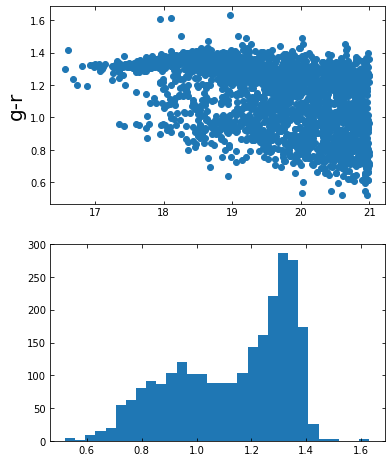

In [9]:
f,ax = plt.subplots(2,1,figsize = (6,8))
cc1 = plot_cmhist(ax = ax[0],c1 = 'g',c2 = 'r',ref_m='y',z_m = z_m,cut = 21)
ax[1].hist(cc1,bins = 30);

Text(0, 0.5, '$p(x)$')

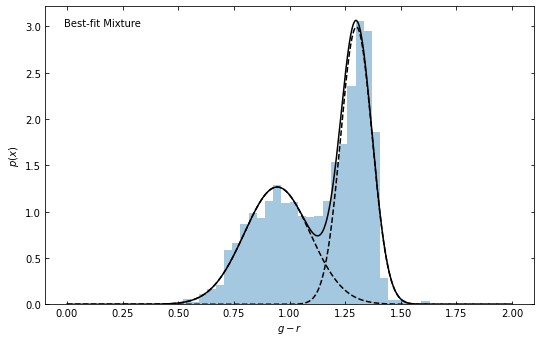

In [14]:
#------------------------------------------------------------
#  Best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data
X = cc1.reshape(-1,1)
N = np.array([2])
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(111)
M_best = models[np.argmin(BIC)]

x = np.linspace(0, 2, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$g-r$')
ax.set_ylabel('$p(x)$')